In [217]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.palettes import mpl
from bokeh.transform import linear_cmap
from bokeh.models import  ColorBar, NumeralTickFormatter

### Vizualizáljuk az összes esetek számát és a halálozások számát térképen

In [218]:
output_notebook()

Loading BokehJS ...

In [219]:
def adatcsvkeep(start_date: str,end_date: str,countries: list,keep_columns: list):
    '''
    beolvassa a csv fájlt és csinál belőle egy pandas adatszerkezetet,

    start_date, end_date stringek yyyy-mm-dd alakban,

    countries egy string lista azon országokból, amiket meg akarunk tartani,
    
    delete_columns string lista azon oszlopokról, amiket ki akarunk törölni
    '''  
    df = pd.read_csv('owid-covid-data.csv')                
    df = df[df["iso_code"].isin(countries)]
    df = df[(df["date"]>=start_date) & (df["date"]<=end_date)]
    df = df[keep_columns]

    return df
eu_members= [
    "AUT",  # Austria
    "BEL",  # Belgium
    "BGR",  # Bulgaria
    "CYP",  # Cyprus
    "CZE",  # Czech Republic
    "DEU",  # Germany
    "DNK",  # Denmark
    "EST",  # Estonia
    "ESP",  # Spain
    "FIN",  # Finland
    "FRA",  # France
    "GRC",  # Greece
    "HRV",  # Croatia
    "HUN",  # Hungary
    "IRL",  # Ireland
    "ITA",  # Italy
    "LTU",  # Lithuania
    "LUX",  # Luxembourg
    "LVA",  # Latvia
    "MLT",  # Malta
    "NLD",  # Netherlands
    "POL",  # Poland
    "PRT",  # Portugal
    "ROU",  # Romania
    "SWE",  # Sweden
    "SVN",  # Slovenia
    "SVK",  # Slovakia
]

In [220]:
data=adatcsvkeep("2023-12-31","2023-12-31",eu_members,["iso_code","date","location","total_cases","total_deaths"])

In [221]:
eu_cities = {
    'AUT': (48.2082, 16.3738),
    'BEL': (50.8503, 4.3517),
    'BGR': (42.6977, 23.3219),
    'HRV': (45.8150, 15.9819),
    'CYP': (35.1856, 33.3823),
    'CZE': (50.0755, 14.4378),
    'DNK': (55.6761, 12.5683),
    'EST': (59.4370, 24.7536),
    'FIN': (60.1695, 24.9354),
    'FRA': (48.8566, 2.3522),
    'DEU': (52.5200, 13.4050),
    'GRC': (37.9838, 23.7275),
    'HUN': (47.4979, 19.0402),
    'IRL': (53.3498, -6.2603),
    'ITA': (41.9028, 12.4964),
    'LVA': (56.9496, 24.1052),
    'LTU': (54.6872, 25.2797),
    'LUX': (49.8153, 6.1296),
    'MLT': (35.8989, 14.5146),
    'NLD': (52.3676, 4.9041),
    'POL': (52.2297, 21.0122),
    'PRT': (38.7223, -9.1393),
    'ROU': (44.4268, 26.1025),
    'SVK': (48.1486, 17.1077),
    'SVN': (46.0569, 14.5058),
    'ESP': (40.4168, -3.7038),
    'SWE': (59.3293, 18.0686)
}

A bokeh csak mercator koordinátákkal tud számolni, ezért a lon-lan koordinátákat át kell váltani

In [222]:
def mercator_coord(coord):
    
    lat = coord[0]
    lon = coord[1]
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return [x, y]

eu_cities_mercator=[mercator_coord(value) for value in eu_cities.values()]
eu_mercator_x=[eu_cities_mercator[i][0] for i in range(len(eu_cities_mercator))]
eu_mercator_y=[eu_cities_mercator[i][1] for i in range(len(eu_cities_mercator))]

In [223]:
total_cases=[]
for key in eu_cities:
    for index in data.index:
        if data["iso_code"][index]==key:
            total_cases.append(data["total_cases"][index])

### Összes esetek száma

In [224]:
printdata={
    'total_cases' : total_cases,
    'mercator_x' : eu_mercator_x,
    'mercator_y' : eu_mercator_y,
    'country' : [key for key in eu_cities]
    }
df=pd.DataFrame(printdata)
color_mapper = linear_cmap(field_name = 'total_cases', palette = mpl['Inferno'][11][::-1], low = df['total_cases'].min(), high = df['total_cases'].max())
source = ColumnDataSource(data=df)
tooltips = [("Összes eset","@total_cases"), ("Ország","@country") ]
p = figure(title = 'Összes esetek száma az EU-s tagállamokban',
           x_axis_type="mercator", y_axis_type="mercator", x_axis_label = 'Hosszúsági kör', 
           y_axis_label = 'Szélességi kör', tooltips = tooltips)
p.add_tile("CartoDB Positron retina")
p.circle(x = 'mercator_x', y = 'mercator_y', color = color_mapper, source=source, size=30, fill_alpha = 0.7)
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))
p.add_layout(color_bar, 'right')
show(p)

In [225]:
total_deaths=[]
for key in eu_cities:
    for index in data.index:
        if data["iso_code"][index]==key:
            total_deaths.append(data["total_deaths"][index])

### Halálozások száma

In [226]:
printdata1={
    'total_deaths' : total_deaths,
    'mercator_x' : eu_mercator_x,
    'mercator_y' : eu_mercator_y,
    'country' : [key for key in eu_cities]
    }
df=pd.DataFrame(printdata1)
color_mapper = linear_cmap(field_name = 'total_deaths', palette = mpl['Inferno'][11][::-1], low = df['total_deaths'].min(), high = df['total_deaths'].max())
source = ColumnDataSource(data=df)
tooltips = [("Összes haláleset","@total_deaths"), ("Ország","@country") ]
p = figure(title = 'Halálozások száma az EU-s tagállamokban',
           x_axis_type="mercator", y_axis_type="mercator", x_axis_label = 'Hosszúsági kör', 
           y_axis_label = 'Szélességi kör', tooltips = tooltips)
p.add_tile("CartoDB Positron retina")
p.circle(x = 'mercator_x', y = 'mercator_y', color = color_mapper, source=source, size=30, fill_alpha = 0.7)
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))
p.add_layout(color_bar, 'right')
show(p)

### Halálozások és fertőzések száma hetekre lebontva

Text(0.5, 1.0, 'Halálozások hónapokra lebontva')

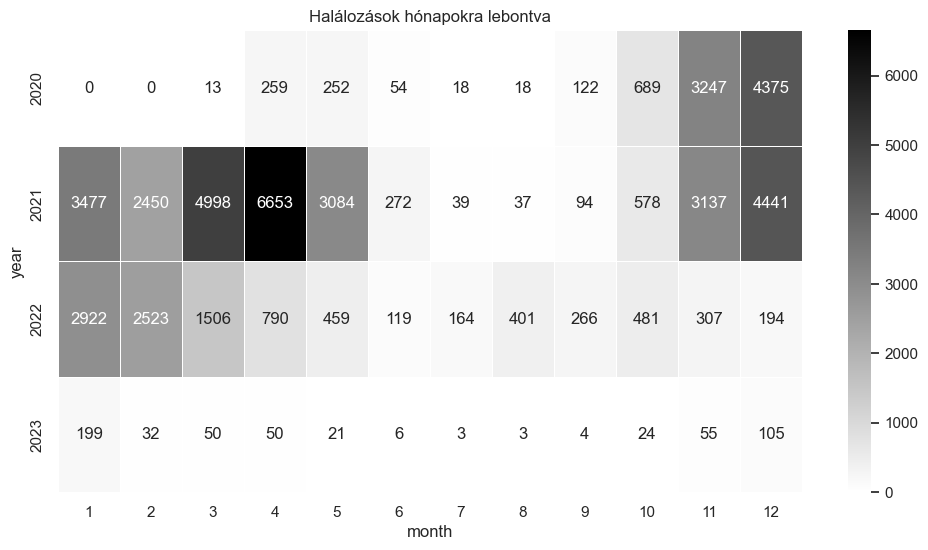

In [227]:
halal=adatcsvkeep("2020-01-01","2023-12-31",["HUN"],["date","new_deaths"])

halal['date'] = pd.to_datetime(halal['date'])

halal['month'] = halal['date'].dt.month
halal['year'] = halal['date'].dt.year
monthly_deaths = halal.groupby(['year', 'month'])['new_deaths'].sum().reset_index()
sns.set_theme()

monthly_deaths = (
    monthly_deaths
    .pivot(index="year", columns="month", values="new_deaths")
)

f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(monthly_deaths, annot=True, fmt=".0f", linewidths=.5, ax=ax, cmap="gist_yarg")
plt.title("Halálozások hónapokra lebontva")

Text(0.5, 1.0, 'Új esetszámok hónapokra lebontva')

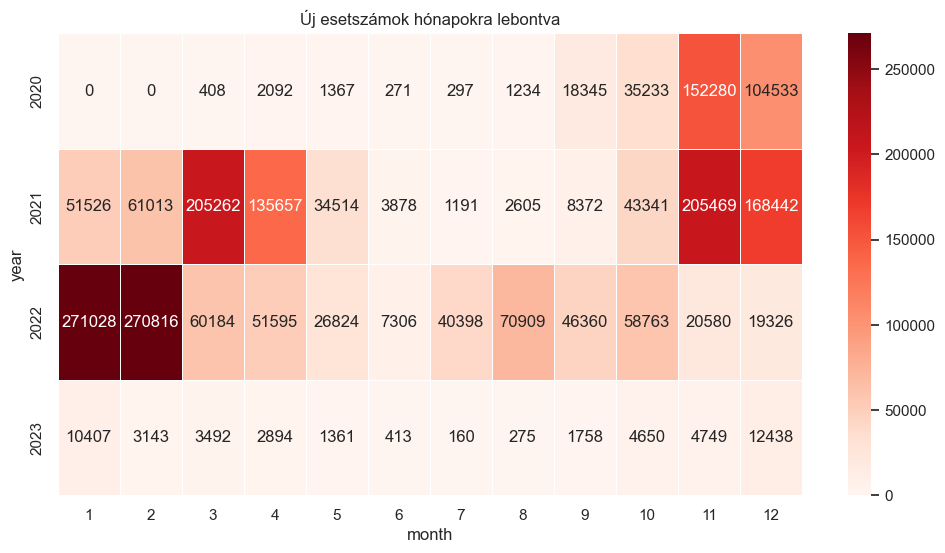

In [228]:
halal=adatcsvkeep("2020-01-01","2023-12-31",["HUN"],["date","new_cases"])

halal['date'] = pd.to_datetime(halal['date'])

halal['month'] = halal['date'].dt.month
halal['year'] = halal['date'].dt.year
monthly_deaths = halal.groupby(['year', 'month'])['new_cases'].sum().reset_index()
sns.set_theme()

monthly_deaths = (
    monthly_deaths
    .pivot(index="year", columns="month", values="new_cases")
)

f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(monthly_deaths, annot=True, fmt=".0f", linewidths=.5, ax=ax, cmap="Reds")
plt.title("Új esetszámok hónapokra lebontva")